In [184]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [205]:
from Processing.get_data import download_with_cache
from Processing.STAT import STATPOP, STATENT
from Area import Area


In [39]:
import pandas as pd
import matplotlib.pyplot as plt

In [33]:
download_with_cache("https://www.bfs.admin.ch/bfsstatic/dam/assets/32686751/master", "STATPOT2023.csv", zip=True, zip_file_name="STATPOP2023.csv", method="GET")

('data\\1_downloaded\\STATPOT2023.csv', datetime.date(2025, 1, 2))

In [38]:
df = pd.read_csv('data\\1_downloaded\\STATPOT2023.csv', sep=";")
df

,ERHJAHR,PUBJAHR,RELI,E_KOORD,N_KOORD,BBTOT,BB11,BB12,BB13,BB14,...,BB55,BB56,HPTOT,HP01,HP02,HP03,HP04,HP05,HP06,HPI
0,2023,2024,48621114,2486200,1111400,5,4,3,3,0,...,0,0,3,3,3,0,0,0,0,1.0
1,2023,2024,48621115,2486200,1111500,3,3,0,0,0,...,0,0,3,3,0,0,0,0,0,1.0
2,2023,2024,48631114,2486300,1111400,4,4,0,0,0,...,0,0,3,0,0,0,3,0,0,1.0
3,2023,2024,48631117,2486300,1111700,3,3,0,0,0,...,0,0,3,0,0,3,0,0,0,1.0
4,2023,2024,48641116,2486400,1111600,30,22,8,7,0,...,0,0,11,3,3,5,3,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347403,2023,2024,83101690,2831000,1169000,3,3,0,0,0,...,0,0,3,0,0,3,0,0,0,1.0
347404,2023,2024,83101692,2831000,1169200,3,3,0,0,0,...,0,0,3,3,3,0,0,0,0,1.0
347405,2023,2024,83111692,2831100,1169200,3,3,0,0,0,...,0,0,3,3,0,0,0,0,0,1.0
347406,2023,2024,83111693,2831100,1169300,9,9,0,0,0,...,0,0,4,3,3,3,0,0,0,1.0


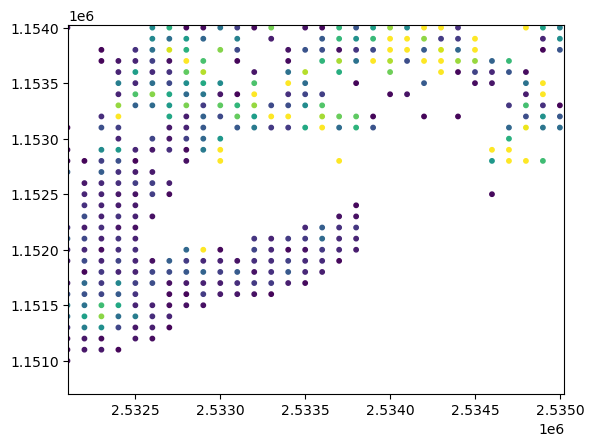

In [57]:
plt.scatter(data=df, x="E_KOORD", y="N_KOORD", c="BBTOT", s=10,  vmin=0, vmax=200)
plt.xlim(2532106,2535027)
plt.ylim(1150700,1154028)
plt.show()

In [47]:
df.BBTOT.max()

np.int64(4046)

In [65]:
next(iter(ASSETS_PER_YEAR.keys()))

2023

In [69]:
epfl = Area("EPFL", 2532106, 2535027, 1150700, 1154028)
epfl.plot_interactive()

In [363]:
filename, _ = download_with_cache(
    f"https://www.bfs.admin.ch/bfsstatic/dam/assets/{32686751}/master",
    f"STATPOP{2023}.csv",
    zip=True,
    zip_file_name=f"STATPOP{2023}.csv",
    method="GET"
)

df = pd.read_csv(filename, sep=";")

# Keep only hectares inside the area (i.e. with at least one square meter inside the area)
df = df.loc[epfl.is_inside_hecto(X = df["E_KOORD"], Y = df["N_KOORD"])]

#Set RELI as index
df = df.set_index("RELI")

In [364]:
households_per_size = df[[f"HP0{i+1}" for i in range(6)]].rename(columns=lambda i : int(i[-1])).copy(deep=True)
households_per_size


,1,2,3,4,5,6
RELI,,,,,,
53211510,0,0,0,0,0,3
53211511,0,3,0,3,0,0
53211512,3,0,3,3,0,0
53211513,4,3,3,4,0,0
53211514,12,10,3,8,0,3
...,...,...,...,...,...,...
53501532,8,5,5,3,3,3
53501533,0,3,0,0,0,0
53501538,18,6,6,3,0,0


In [365]:
households_per_size = households_per_size.where(households_per_size!=3, 1)
households_per_size

,1,2,3,4,5,6
RELI,,,,,,
53211510,0,0,0,0,0,1
53211511,0,1,0,1,0,0
53211512,1,0,1,1,0,0
53211513,4,1,1,4,0,0
53211514,12,10,1,8,0,1
...,...,...,...,...,...,...
53501532,8,5,5,1,1,1
53501533,0,1,0,0,0,0
53501538,18,6,6,1,0,0


In [366]:
diff = df["BBTOT"] - (households_per_size*households_per_size.columns).sum(axis=1)
diff

RELI
53211510    0
53211511    0
53211512    1
53211513    5
53211514    0
           ..
53501532    6
53501533    1
53501538    0
53501539    9
53501540    9
Length: 374, dtype: int64

In [367]:
diff = df["BBTOT"] - (households_per_size*households_per_size.columns).sum(axis=1)
df["BBTOT_corrected"] = df["BBTOT"]
def correct_households_numbers(row):
    difference = diff.loc[row.name]
    availlable = row[row==1].index.to_list()
    if len(availlable) > 0:
        condition = (lambda x : x<=3) if df.loc[row.name, "BBTOT"] == 3 else (lambda x : x==difference)
        combinaisons = [seq for i in range(difference//min(availlable), 0, -1)
                        for seq in itertools.combinations_with_replacement(availlable, i)
                        if condition(sum(seq))]
    
        combinaison = ()
        if len(combinaisons) > 0:
            combinaison = random.choice(combinaisons)
        else :
            if df.loc[row.name, "BBTOT"] == 3:
                df.loc[row.name, "BBTOT_corrected"] = sum(availlable)
            elif row[6] >0 :
                while len(combinaisons)==0 and difference > 1:
                    difference -= 1
                    combinaisons = [seq for i in range(difference//min(availlable), 0, -1)
                                    for seq in itertools.combinations_with_replacement(availlable, i)
                                    if sum(seq) == difference]
                if len(combinaisons)>0:
                    combinaison = random.choice(combinaisons)
        
        for i in combinaison:
            row[i] += 1
    
    return row
households_per_size.apply(correct_households_numbers, axis=1)

,1,2,3,4,5,6
RELI,,,,,,
53211510,0,0,0,0,0,1
53211511,0,1,0,1,0,0
53211512,2,0,1,1,0,0
53211513,4,2,2,4,0,0
53211514,12,10,1,8,0,1
...,...,...,...,...,...,...
53501532,8,5,5,1,1,2
53501533,0,1,0,0,0,0
53501538,18,6,6,1,0,0


In [370]:
households_per_size.merge(df["BBTOT_corrected"], left_index=True, right_index=True).merge((df["BBTOT_corrected"] - (households_per_size*households_per_size.columns).sum(axis=1)).rename("diff"), left_index=True, right_index=True)[((df["BBTOT_corrected"] - (households_per_size*households_per_size.columns).sum(axis=1))>0)]

,1,2,3,4,5,6,BBTOT_corrected,diff
RELI,,,,,,,,
53211540,0,0,0,0,1,1,12,1
53231515,32,20,6,9,1,1,138,1
53231525,0,4,0,1,0,1,19,1
53241535,0,1,0,0,0,0,85,83
53251515,7,1,0,1,1,0,19,1
53251528,2,0,0,0,0,0,3,1
53251534,21,16,15,7,1,2,144,1
53261534,19,13,11,14,1,4,164,1
53261538,8,6,5,5,1,2,74,2


In [318]:
[seq for i in range(len(availlable), 0, -1)
for seq in itertools.combinations_with_replacement(availlable, i)
if sum(seq) == 6]

[(6,)]

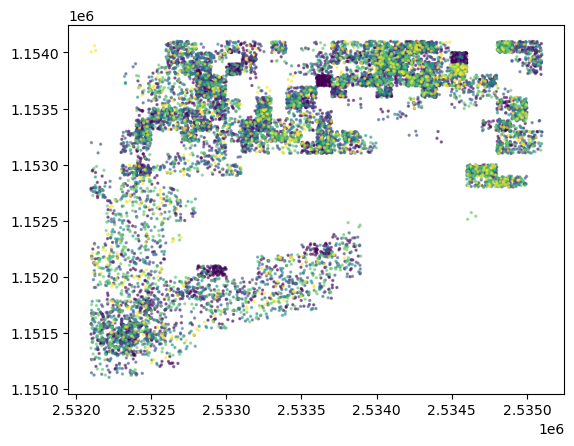

In [223]:
population = STATPOP(epfl, precision_in_meter=1, seed = 200)
plt.scatter(population.get_points(["POPULATION"])[:, 0], population.get_points(["POPULATION"])[:, 1], c=population.get_points(["POPULATION"])[:, 2], alpha=0.5, s=2)
plt.show()

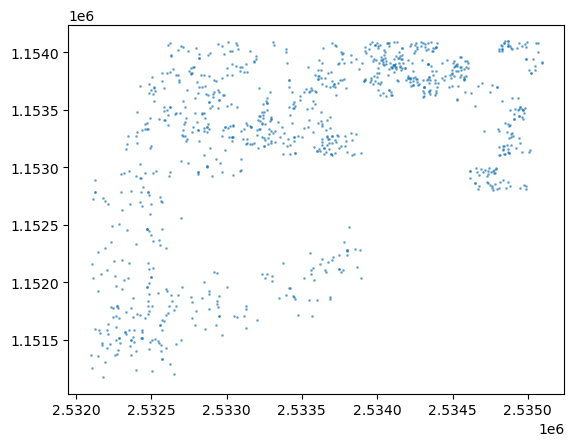

array([[2533991.5, 1153937.5],
       [2532595.5, 1151426.5],
       [2532440.5, 1151514.5],
       ...,
       [2532269.5, 1151616.5],
       [2532947.5, 1151704.5],
       [2533720.5, 1153236.5]], shape=(1000, 2))

In [213]:
pop_demand = population.generate_n(1000, seed = 10)
plt.scatter(pop_demand[:, 0], pop_demand[:, 1], alpha=0.5, s=1)
plt.show()
pop_demand

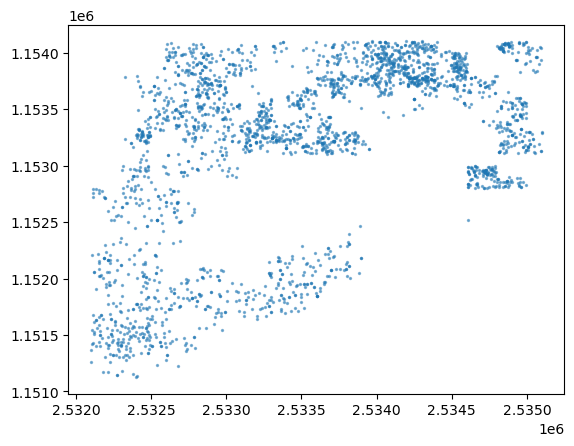

In [216]:
pop_demand = population.generate_per_population(0.1, seed = 100)
plt.scatter(pop_demand[:, 0], pop_demand[:, 1], alpha=0.5, s=2)

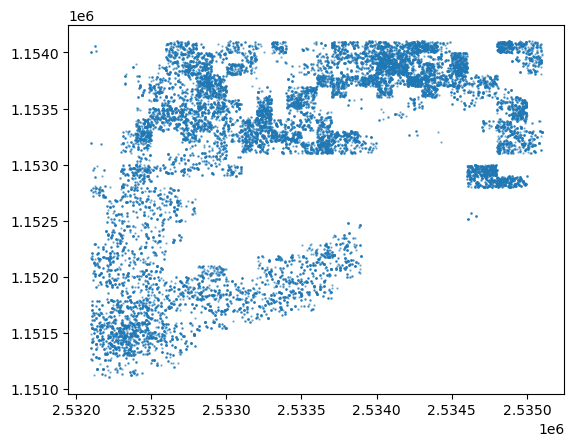

In [218]:
pop_demand = population.generate_per_population(1, seed = 100)
plt.scatter(pop_demand[:, 0], pop_demand[:, 1], alpha=0.5, s=0.5)
plt.show()

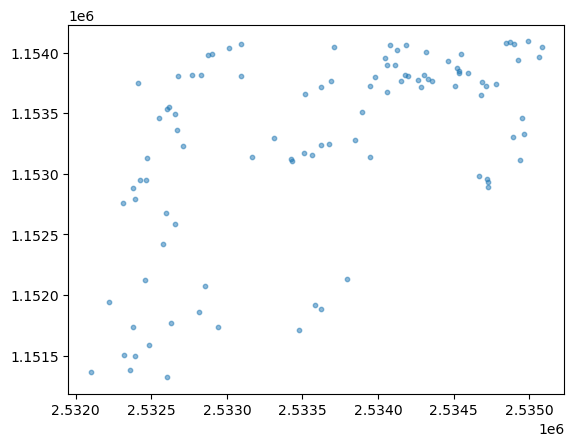

In [221]:
pop_demand = population.generate_n(100, seed = 100)
plt.scatter(pop_demand[:, 0], pop_demand[:, 1], alpha=0.5, s=10)
plt.show()

In [186]:
entreprises = STATENT(epfl)
entreprises.df

,POSITION_X,POSITION_Y,SHOPS,SHOPS_EMP,SHOPS_ETP,SHOPS_0,SHOPS_10,SHOPS_50,SHOPS_250
12331,2532100,1151300,0,0,0.0,0,0,0,0
12332,2532100,1151400,0,0,0.0,0,0,0,0
12333,2532100,1151500,0,0,0.0,0,0,0,0
12334,2532100,1151700,0,0,0.0,0,0,0,0
12335,2532100,1151900,0,0,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
13730,2535000,1153600,0,0,0.0,0,0,0,0
13731,2535000,1153700,0,0,0.0,0,0,0,0
13732,2535000,1153800,0,0,0.0,0,0,0,0
13733,2535000,1153900,4,4,4.0,4,0,0,0


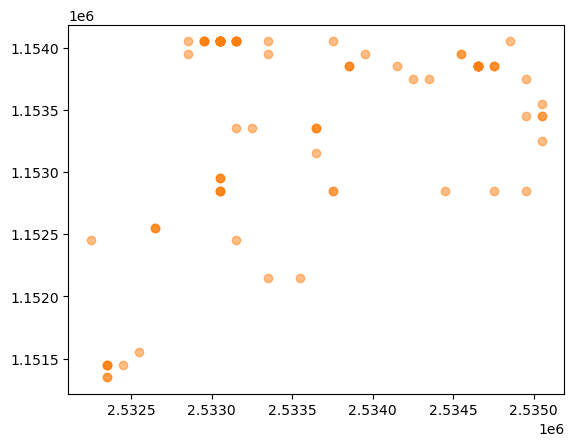

array([[2534650, 1153850],
       [2532350, 1151350],
       [2533850, 1153850],
       [2534550, 1153950],
       [2533150, 1154050],
       [2533050, 1152850],
       [2532950, 1154050],
       [2534650, 1153850],
       [2532950, 1154050],
       [2532650, 1152550],
       [2534250, 1153750],
       [2535050, 1153250],
       [2532250, 1152450],
       [2533150, 1154050],
       [2534650, 1153850],
       [2533750, 1152850],
       [2534450, 1152850],
       [2533050, 1152950],
       [2534950, 1153450],
       [2534350, 1153750],
       [2533350, 1152150],
       [2532850, 1154050],
       [2533050, 1154050],
       [2534150, 1153850],
       [2533150, 1152450],
       [2533050, 1154050],
       [2533750, 1154050],
       [2533150, 1154050],
       [2533950, 1153950],
       [2533650, 1153350],
       [2534650, 1153850],
       [2533150, 1154050],
       [2534950, 1152850],
       [2533050, 1154050],
       [2532650, 1152550],
       [2533050, 1154050],
       [2532850, 1153950],
 

In [197]:
ent_sources = entreprises.generate_n(100, weights="SHOPS_ETP", seed = 10)
plt.scatter(ent_sources[:, 0], ent_sources[:, 1], alpha=0.5, c="C1")
plt.show()
ent_sources

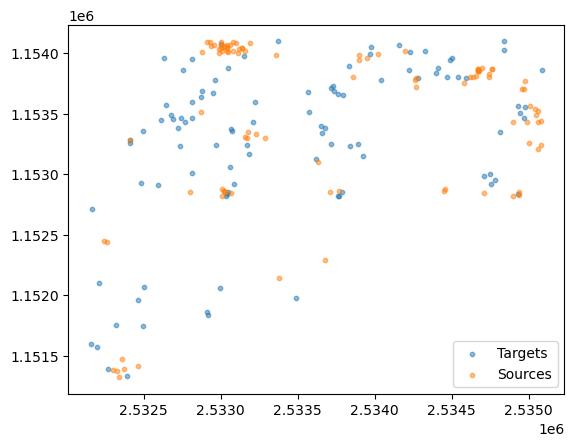

In [198]:
pop_demand_jitter = population.generate_n(100, 1, seed = 100)
plt.scatter(pop_demand_jitter[:, 0], pop_demand_jitter[:, 1], alpha=0.5, s=10, label="Targets")
ent_sources_jitter = entreprises.generate_n(100, 10, weights="SHOPS_ETP", seed = 200)
plt.scatter(ent_sources_jitter[:, 0], ent_sources_jitter[:, 1], alpha=0.5, s=10, c="C1", label="Sources")
plt.legend()
plt.show()

In [101]:
import numpy as np

In [141]:
np.random.Generator.integers(5, size=(10,2)) * 20

TypeError: integers() takes at least 1 positional argument (0 given)

In [145]:
np.random.default_rng?

Signature:      np.random.default_rng(seed=None)
Call signature: np.random.default_rng(*args, **kwargs)
Type:           cython_function_or_method
String form:    <cyfunction default_rng at 0x000002173823DA40>
Docstring:     
default_rng(seed=None)
Construct a new Generator with the default BitGenerator (PCG64).

    Parameters
    ----------
    seed : {None, int, array_like[ints], SeedSequence, BitGenerator, Generator, RandomState}, optional
        A seed to initialize the `BitGenerator`. If None, then fresh,
        unpredictable entropy will be pulled from the OS. If an ``int`` or
        ``array_like[ints]`` is passed, then all values must be non-negative and will be
        passed to `SeedSequence` to derive the initial `BitGenerator` state. One may also
        pass in a `SeedSequence` instance.
        Additionally, when passed a `BitGenerator`, it will be wrapped by
        `Generator`. If passed a `Generator`, it will be returned unaltered.
        When passed a legacy `Rando